In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')
sns.set_palette('viridis')

from bertopic import BERTopic

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re

from tqdm import tqdm
tqdm.pandas()



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinweiskirch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kevinweiskirch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
df = pd.read_excel('final_corpus.xlsx', index_col=[0])

In [12]:
df.head(2)

,index,description,keywords,section,source,title,url,f_dates,missing_texts,filenames
2,2,View updated wildfire maps and the latest air ...,keywords not available for this source,NaN,CNN,Wildfire map and air quality tracker,https://www.cnn.com/interactive/2020/weather/w...,2020-09-14,Air quality\n\nWildfire smoke creates fine par...,Speech_2.txt
3,3,Track the latest severe storm activity with CN...,keywords not available for this source,NaN,CNN,CNN Storm Tracker,https://www.cnn.com/interactive/storm-tracker/,2020-01-01,Tracking severe weather\n\nLoading interactive...,Speech_3.txt


In [13]:
df.rename({'f_dates': 'Date', 'missing_texts': "Text"}, axis=1, inplace=True)

In [38]:
template_text = df['Text'].value_counts()[0]
df = df[df['Text'] != template_text]
df.shape

(29805, 14)

In [70]:
top_texts = df['Text'].value_counts().to_frame()
top_texts.reset_index(inplace=True)
top_texts.rename({'index': "text", 'Text': 'count'}, axis=1, inplace=True)

texts_to_drop = list(top_texts['text'][0:7].values)
df = df[~df['Text'].isin(texts_to_drop)]
df.shape

(28586, 14)

In [157]:
def remove_templates(text):
    text = str(text)    

    text = text.replace("All quotes delayed a minimum of 15 minutes.", " ")
    text = text.replace("Discover Thomson Reuters, By", " ")
    text = text.replace('Discover Thomson Reuters', " ")
    text = text.replace("Min Read", " " )
    text = text.replace(" By, ", " ")
    text = text.replace("See , of exchanges and delays.'", " " )
    text  = text.replace("Reuters provides business, financial, national and international news to professionals via desktop terminals, the world's media organizations, industry events and directly to consumers", " ")
    text = text.replace("Build the strongest argument relying on authoritative content, attorney-editor expertise, and industry defining technology", " ")
    text = text.replace("The most comprehensive solution to manage all your complex and ever-expanding tax and compliance needs", " ")
    text = text.replace("The industry leader for online information for tax, accounting and finance professionals", " ")
    text = text.replace("Access unmatched financial data, news and content in a highly-customised workflow experience on desktop, web and mobile", " ")
    text = text.replace("Browse an unrivalled portfolio of real-time and historical market data and insights from worldwide sources and expert.", " ")
    text = text.replace("Screen for heightened risk individual and entities globally to help uncover hidden risks in business relationships and human networks", " ")
    text = text.replace("of exchanges and delays", " ")
    text = text.replace("Reuters, the news and media division of", " ")
    text = text.replace("Thomson Reuters, is the world’s largest multimedia news provider, reaching billions of people worldwide every day", " ")
    text = text.replace("is the world’s largest multimedia news provider, reaching billions of people worldwide every day", " ")
    text = text.replace("delayed by at least 15 minutes", " ")
    return text


df['Text'] = df['Text'].progress_apply(remove_templates)

100%|██████████| 28586/28586 [00:01<00:00, 21437.03it/s]


In [158]:
df = df.dropna(subset='Date')
df.shape

(28586, 14)

In [159]:
df['Year'] = df['Date'].dt.to_period("Y").astype(str)
df['Month'] = df['Date'].dt.to_period("M").astype(str)
df['Week'] = df['Date'].dt.to_period("W").astype(str)

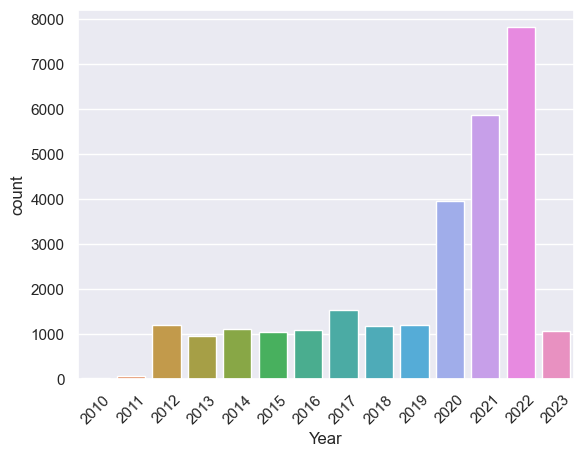

In [160]:
df = df.sort_values(by='Date')
df_2010s = df[df['Year'] >= '2010']
sns.countplot(data=df_2010s, x='Year')
plt.xticks(rotation=45)
plt.show()

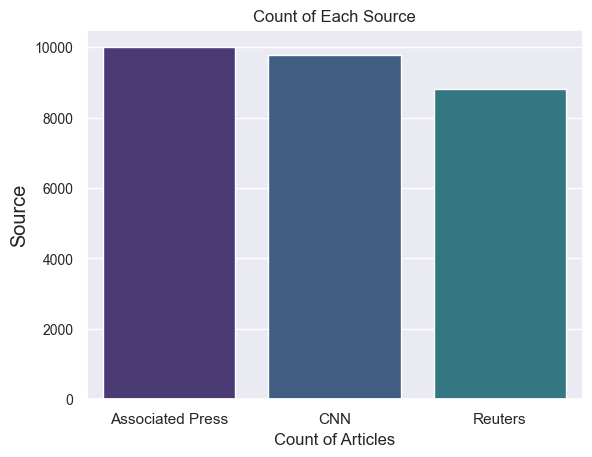

In [161]:
sns.countplot(data=df, x='source', order=df['source'].value_counts().index)
plt.title('Count of Each Source')
plt.xlabel("Count of Articles")
plt.ylabel("Source", fontsize='large')
plt.yticks(fontsize='small')
plt.show()

In [162]:
stop = stopwords.words('english')
additional_stops = ['delayed', 'minimums', '15', 'minutes', 'news', 'via', 'desktops',
                    'multimedia', 'providers', 'reuters', 'reaching', 'thomsom',
                    'worldwide', 'terminals', 'mediums', 'organizations', 'events',
                    'people', 'professionals', 'businesses']
for word in additional_stops:
    stop.append(word)
    wnl = WordNetLemmatizer()
    lemmatized_noun = wnl.lemmatize(str(word), pos='n')
    lemmatized_verb = wnl.lemmatize(str(word), pos='v')
    lemmatized_adj = wnl.lemmatize(str(word), pos='a')
    stop.append(lemmatized_noun)
    stop.append(lemmatized_verb)
    stop.append(lemmatized_adj)
print(stop)

df['cleaned_full_text'] = df['Text'].progress_apply(lambda x: " ".join([word.lower() for word in str(x).split() if word not in stop]))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

100%|██████████| 28586/28586 [00:23<00:00, 1237.09it/s]


In [171]:
corpus = df['cleaned_full_text'].to_list()
assert(len(corpus) == df.shape[0])

In [163]:
def trigram_clean(text):
    wnl = WordNetLemmatizer()
    text = text.lower()
    words = re.sub(r'[^\w\s]', '', text).split()
    allwords = [wnl.lemmatize(word) for word in words if word not in stop]
    return allwords

In [164]:
def make_ngrams(allwords, n):
    n_grams = pd.DataFrame({
        "n_gram": (pd.Series(nltk.ngrams(allwords, n)).value_counts().index),
        "value_counts": (pd.Series(nltk.ngrams(allwords, n)).value_counts())
    })
    return n_grams

In [165]:
allwords = trigram_clean("".join(str(df['cleaned_full_text'].tolist())))


In [166]:
all_trigrams = make_ngrams(allwords, 3)


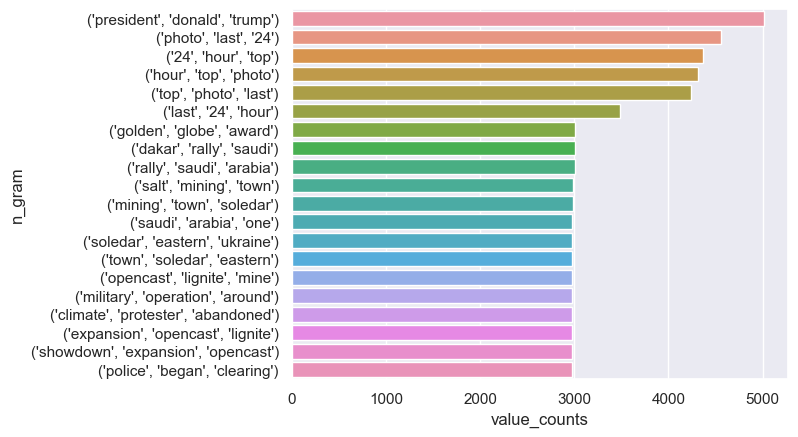

In [167]:
top_trigrams_all_corpus = all_trigrams.iloc[:20]
sns.barplot(data=top_trigrams_all_corpus, y='n_gram', x='value_counts')
plt.show()

In [172]:
topic_model_all_corpus = BERTopic(verbose=True, diversity=.25, n_gram_range=(1,5),
                        min_topic_size=25, nr_topics=25)
topics_all, probs_all = topic_model_all_corpus.fit_transform(corpus)


Batches: 100%|██████████| 894/894 [13:23<00:00,  1.11it/s]
2023-01-15 13:23:06,630 - BERTopic - Transformed documents to Embeddings
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-01-15 13:23:26,273 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabli

2023-01-15 13:23:28,062 - BERTopic - Clustered reduced embeddings
2023-01-15 14:37:07,728 - BERTopic - Reduced number of topics from 196 to 26


In [173]:
topic_model_all_corpus.save('TopicModelAllCorpus.model')

/Users/kevinweiskirch/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [174]:
topic_model_all_corpus.get_topic_info()

,Topic,Count,Name
0,-1,16883,-1_new_trump_president_two
1,0,2223,0_2015_our top photos_photos last_photos last 24
2,1,997,1_economy_stocks_markets_chinese
3,2,809,2_russian_ukraine_ukrainian_putin
4,3,695,3_time_movie_actor_also
5,4,626,4_oil_prices_reuters_russia
6,5,588,5_how this beach name nan_this beach name nan ...
7,6,439,6_olympic_olympics_womens_athletes
8,7,426,7_tesla_musk_cars_billion
9,8,420,8_immigration_children_trump_immigrants


In [175]:
all_hierarchical = topic_model_all_corpus.hierarchical_topics(docs=corpus)
all_hierarchical_fig = topic_model_all_corpus.visualize_hierarchy(hierarchical_topics=all_hierarchical)
all_hierarchical_fig.show()

100%|██████████| 24/24 [00:16<00:00,  1.50it/s]


In [176]:
all_hierarchical_fig.write_html("all_hierarchical.html")

In [177]:
topics_all_corpus_over_time = topic_model_all_corpus.topics_over_time(
                                docs=corpus,
                                timestamps=df['Date'].to_list(),
                                nr_bins=100, evolution_tuning=True, global_tuning=False
    
)


58it [14:31:23, 901.44s/it] 


In [178]:
topics_all_corpus_over_time_fig = topic_model_all_corpus.visualize_topics_over_time(topics_all_corpus_over_time)
topics_all_corpus_over_time_fig.show()